In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jul 12 14:17:33 2016
@author: jack
INSTRUCTIONS TO USE
======
To use, just run the code.  you will be prompted to select a file.  After that 
it will automatically perform contrast limited adaptive histogram equalization 
(CLAHE).  It will then use the cross correlation function, followed by 
post-processing steps to remove outliers and interpolate those spots.
The user is then asked whether they would like to save the results to images 
and CSV files.
CITATIONS
======
This is a modified version of the example script for openPIV.
<http://www.openpiv.net/openpiv-python/src/tutorial.html>
"""

import openpiv.tools
#import openpiv.process
import openpiv.scaling
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tkinter import Tk
from tkinter.filedialog import askopenfilenames, askopenfilename
import tkinter.messagebox
import timeit
import scipy
from scipy.signal import kaiserord, lfilter, firwin, freqz
import time
import imageio


#------------------------------------------------------------
# function to open image
def openImage():
    Tk() #.withdraw()
    file_opt = options = {}
    #options['initialdir'] = '/home/jack/Pictures'
    options['title'] = 'Select an image to process'
    imgFilename = askopenfilenames(**file_opt)
    fo = 1
    filepath = str(imgFilename)
    filepath = filepath[:-4]
    while fo:
        filepath = filepath[:-1]
        if filepath[-1] == '/':
            fo = 0
    refImgFilename = filepath + "reference.JPG')"
    name = imgFilename[int(len(filepath[2:-3]))-2:-4]
    imgFilename = str(imgFilename)[2:-3]
    refImgFilename = str(refImgFilename[2:-2])
    return(imgFilename, refImgFilename, filepath[2:-3], name)




In [2]:
#------------------------------------------------------------
# function to display image
def displayImage(image):
    plt.figure()
    X = [ (2,1,1), (2,1,2) ]
    for nrows, ncols, plot_number in X:
        plt.subplot(nrows, ncols, plot_number)
        if plot_number == 1:
            imgMean = np.mean(image.ravel())
            imgStd = np.std(image.ravel())
            clim = (imgMean-2*imgStd,imgMean+2*imgStd)
            plt.imshow(image, cmap='gray', clim=clim)
            plt.title('image')
        if plot_number == 2:
            plt.hist(image.ravel(), 256)
            plt.title('histogram')
        plt.show()


#------------------------------------------------------------

In [3]:
# select images
imgFilename, refImgFilename, filepath, name = openImage()
img = cv2.imread(imgFilename,0)
refimg = cv2.imread(refImgFilename,0)
#displayImage(img)


#------------------------------------------------------------


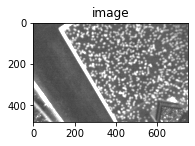

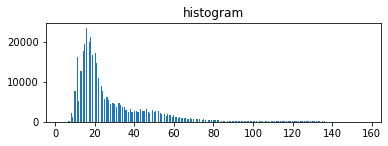

In [4]:
# use contrast limited adaptive histogram equalization (CLAHE)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img = clahe.apply(img)
displayImage(img)


#------------------------------------------------------------


In [5]:
# perform PIV
window_size=24
overlap=12
dt=0.02
search_area_size=64

start = timeit.default_timer()
u, v, sig2noise = openpiv.process.extended_search_area_piv(refimg.astype(np.int32), 
                        img.astype(np.int32), window_size=window_size, overlap=overlap, 
                        dt=dt, search_area_size=search_area_size, sig2noise_method='peak2peak' )
stop = timeit.default_timer()
print('time ellapsed performing cross correlation: ' + str(stop-start) + ' s.')

x, y = openpiv.process.get_coordinates( image_size=img.shape, window_size=24, overlap=12 )


#------------------------------------------------------------


AttributeError: module 'openpiv' has no attribute 'process'

In [6]:
# perform post-processing

# invalid vectors are set to NaN
u, v, mask = openpiv.validation.sig2noise_val( u, v, sig2noise, threshold = 1.5 )

# this interpolates the missing vectors
u, v = openpiv.filters.replace_outliers( u, v, method='localmean', kernel_size=2)

# scale the results so they're in correct units
x, y, u, v = openpiv.scaling.uniform(x, y, u, v, scaling_factor = 96.52 )

# blur to remove noise
u = scipy.ndimage.filters.gaussian_filter(u, 1, order=0)
v = scipy.ndimage.filters.gaussian_filter(v, 1, order=0)


#------------------------------------------------------------


AttributeError: module 'openpiv' has no attribute 'validation'

In [ ]:
# plot results
lowerU = np.mean(u)-3*np.std(u)
upperU = np.mean(u)+3*np.std(u)
lowerV = np.mean(v)-3*np.std(v)
upperV = np.mean(v)+3*np.std(v)

plt.figure()
plt.subplot(121)
plt.imshow(u,cmap='gray', clim=(lowerU,upperU))
plt.subplot(122)
plt.imshow(v,cmap='gray', clim=(lowerV,upperV))

#plt.figure()
#plt.quiver( x, y, u, v )


#------------------------------------------------------------
 




In [ ]:
# ask user if they would like to save files
saveChoice = tkinter.messagebox.askyesno('Save results?','Would you like to save the results?')
if saveChoice:
    name = imgFilename[int(len(filepath))+3:-4]
    outputFilenameU = name + '_H_' + time.strftime("%Y-%m-%d") +'.JPG'
    outputFilenameV = name + '_V_' + time.strftime("%Y-%m-%d") +'.JPG'
    imageio.imwrite( outputFilenameU, u)
    imageio.imwrite( outputFilenameV, v)
    filename = 'BOS_output_'
    np.savetxt( name+'_u.CSV', u, delimiter=",")
    np.savetxt( name+'_v.CSV', v, delimiter=",")
    np.savetxt( name+'_x.CSV', x, delimiter=",")
    np.savetxt( name+'_y.CSV', y, delimiter=",")
    print('results have been saved to the current directory')
else:
    print('You have chosen not to save the images')   